# Генерация текста с помощью RNN


In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [12]:
import os

import numpy as np
import matplotlib.pyplot as plt
from random import sample
import codecs
%matplotlib inline

# Данные


In [13]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
data = None
with open('./datasets/anek.txt', encoding="utf8") as input_file:
    try:
        data = input_file.read()[:-1].split('\n')
    except UnicodeDecodeError:
        print('Error')
    data = [line.replace('<|startoftext|>', ' ') for line in data if len(line) > 0]

In [14]:
len(data)

124166

In [15]:
sample(data, 5)

[' - Тетя Сара, а ваш маленький Изя ест газету...- Пускай ест, она вчерашняя...',
 ' Кажется, я недостаточно тупой, чтобы быть счастливым...',
 ' Первоначально Герасим планировал крестить Муму...',
 ' Не так страшна мама, как ее рисуют первоклассники.',
 ' Вам же неприятно, когда ваши знакомые несут бред и ахинею, так что представьте, какая сложная работа у депутатов.']

Посмотрим на распределение длин:

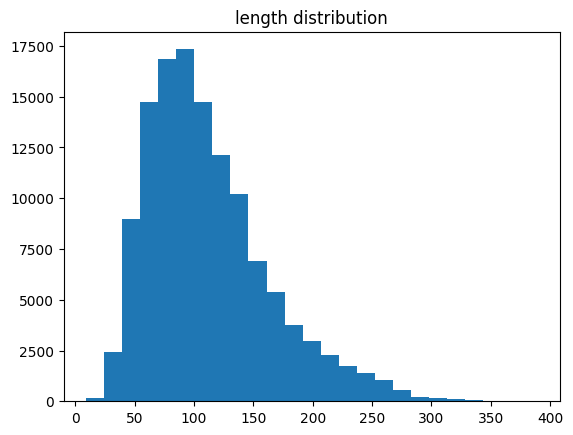

In [16]:
plt.title('length distribution')
plt.hist(list(map(len, data)), bins=25);

# Препроцессинг

In [17]:
#all unique characters go here
tokens = sorted(set(''.join(data)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  211


In [18]:
sample(tokens, 15)

['ч', 'а', 'М', 'Ь', 'c', 'я', '举', '老', '☺', '。', 'P', '»', 'g', 'n', 'Ш']

### Символы -> id

Создадим словарь < символ > -> < id >

In [19]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [20]:
token_to_id

{' ': 0,
 '!': 1,
 '"': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '*': 8,
 '+': 9,
 ',': 10,
 '-': 11,
 '.': 12,
 '/': 13,
 '0': 14,
 '1': 15,
 '2': 16,
 '3': 17,
 '4': 18,
 '5': 19,
 '6': 20,
 '7': 21,
 '8': 22,
 '9': 23,
 ':': 24,
 ';': 25,
 '=': 26,
 '>': 27,
 '?': 28,
 '@': 29,
 'A': 30,
 'B': 31,
 'C': 32,
 'D': 33,
 'E': 34,
 'F': 35,
 'G': 36,
 'H': 37,
 'I': 38,
 'J': 39,
 'K': 40,
 'L': 41,
 'M': 42,
 'N': 43,
 'O': 44,
 'P': 45,
 'Q': 46,
 'R': 47,
 'S': 48,
 'T': 49,
 'U': 50,
 'V': 51,
 'W': 52,
 'X': 53,
 'Y': 54,
 'Z': 55,
 '^': 56,
 '_': 57,
 '`': 58,
 'a': 59,
 'b': 60,
 'c': 61,
 'd': 62,
 'e': 63,
 'f': 64,
 'g': 65,
 'h': 66,
 'i': 67,
 'j': 68,
 'k': 69,
 'l': 70,
 'm': 71,
 'n': 72,
 'o': 73,
 'p': 74,
 'q': 75,
 'r': 76,
 's': 77,
 't': 78,
 'u': 79,
 'v': 80,
 'w': 81,
 'x': 82,
 'y': 83,
 'z': 84,
 '°': 85,
 '²': 86,
 '»': 87,
 '¿': 88,
 '×': 89,
 'Ø': 90,
 'ë': 91,
 'ö': 92,
 '́': 93,
 '̆': 94,
 '̈': 95,
 'ο': 96,
 'π': 97,
 'Ё': 98,
 'А': 99,
 'Б': 100,

In [21]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [22]:
def get_item(str_, ind):
    try:
        return str_[ind]
    except IndexError:
        return ' '

In [23]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of samples into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype)

    for i in range(len(data)):
        for j in range(max_len):
            line_ix = token_to_id[get_item(data[i], j)]
            data_ix[i, j] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [25]:
a = to_matrix(data[:2], token_to_id, max_len=150)

In [23]:
a.shape

(2, 150)

In [24]:
a

array([[  0, 117, 145, 142, 159, 141, 145,   0, 138, 131, 143, 136, 149,
        139, 142,  10,   0, 154, 149, 145,   0, 148, 142, 145, 133, 145,
          0,   2, 146,  29, 147, 144, 145,   2,   0, 144, 131, 132, 139,
        147, 131, 136, 149, 148, 162,   0, 148, 131, 143, 139, 143, 139,
          0, 153, 136, 144, 149, 147, 131, 142, 159, 144, 158, 143, 139,
          0, 141, 142, 131, 133, 139, 155, 131, 143, 139,  12,   0, 109,
        131, 141,   0, 133, 148, 136,   0, 146, 147, 145, 135, 150, 143,
        131, 144, 145,  10,   0, 132, 142, 139, 144,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0, 103, 147, 150, 138, 159, 162,   0, 143, 145, 139,  10,   0,
        154, 149, 145, 132, 158,   0, 148, 145, 145, 149, 133, 136, 149,
       

# Рекуррентные нейронные сети


In [26]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [30]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, hidden_dim=64):
        super(self.__class__,self).__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + hidden_dim, hidden_dim)
        self.rnn_to_logits = nn.Linear(hidden_dim, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) 
        h_next = self.rnn_update(x_and_h) 
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.hidden_dim))

In [28]:
# help(F.log_softmax)

In [31]:
char_rnn = CharRNNCell()

In [32]:
char_rnn

CharRNNCell(
  (embedding): Embedding(211, 16)
  (rnn_update): Linear(in_features=80, out_features=64, bias=True)
  (rnn_to_logits): Linear(in_features=64, out_features=211, bias=True)
)

In [33]:
for parameter in char_rnn.parameters():
    print(parameter.size())

torch.Size([211, 16])
torch.Size([64, 80])
torch.Size([64])
torch.Size([211, 64])
torch.Size([211])


In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [35]:
count_parameters(char_rnn)

22275

### Тренировка сети, RNN loop

In [36]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in data_ix
    :param batch_index: an int32 matrix of shape [batch, time], output of to_matrix(data)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [37]:
from IPython.display import clear_output

char_rnn = CharRNNCell()

opt = torch.optim.Adam(char_rnn.parameters())

history1 = []

In [38]:
len(data)

124166

In [39]:
len(data) / 32

3880.1875

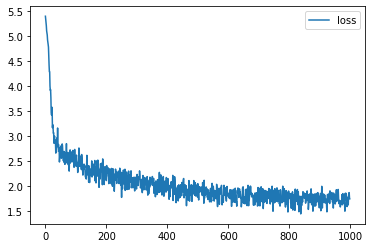

CPU times: user 9min 32s, sys: 23.3 s, total: 9min 56s
Wall time: 1min 24s


In [40]:
%%time

MAX_LENGTH = 150

for i in range(1000):
    batch_ix = to_matrix(sample(data, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens.unsqueeze(-1)))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history1.append(loss.data.numpy())
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.plot(history1,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history1[:100]) > np.mean(history1[-100:]), "RNN didn't converge."

In [41]:
np.mean(history1[-30:])

1.7297142

### RNN: генерация

In [43]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [52]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.6), end='\n\n')

 Сенку к недал коронии бали одолев кой деста модельна в на торорень женко на зосталито стоваты ма ном батить   о труком мени прене сталь дера, серной 

 - Правако моня ивато стичет о менния дазалит ротель в не дасто ето подилого балака в поратили в какостом оплик дарастее не Аглаю растиннають?- В срав

 - Помони слвирое подилото стое корутой ракостования месла равевале, что порумо правоной на ведта тат посто мудра!                                    

 - Не у мону стади проботу сеской ководаю быхорона чина лосе мукой у полелик соботь в гатла назя прорино мари реровак равал поря сжено потелина в прон

 Веднаю сторамто кара, се тобикь порого сов красте бажетровака онари емальный Воме.- Сы калино кохо гостествае да простот что снаки парете в слоблюдил

 - Но не убле, фоль в е мене пороволит пов веть начить блеши меля севирость сади ва и побулего не совакы Дама облини х это поничита бизаманой в нам де

 Падомот?                                                                               

In [73]:
for _ in range(3):
    print(generate_sample(char_rnn, seed_phrase=' Как-то Маша ', temperature=0.6), end='\n\n')

 Как-то Маша вить не ки поло попрувени, с призасны оне поримне о приравеней басто "родолички, кобить слочил мамы.                                     

 Как-то Маша нустой Баты колько стоси не не не выличад, оне мна негдеро новоны.                                                                       

 Как-то Маша оно не поскам петалатя.                                                                                                                  



### Готовые модули

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

### Что еще можно генерировать?

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.


### Встроенные модули Pytorch

In [ ]:
# https://pytorch.org/docs/stable/nn.html#recurrent-layers

In [57]:
sample(data, 5)

[' Жена в сердцах кричит мужу:- Я по горло сыта твоей ревностью! Неужели ты думаешь, что я не знаю, что ты приставил ко мне детектива - этого высокого блондина с зелеными глазами, очень милого, хотя и слегка стеснительного... поначалу...',
 ' Женщины однозначно хитрющие. Ложась смотреть фильм вместе, возбудят мужчину, причем так ухищренно, чтобы он думал, что он инициатор, а потом после секса бурчат недовольно, мол с тобой не один фильм нормально не посмотришь.',
 ' Скользкий пол в ЗАГСе сделал ответ жениха еще ярче.',
 ' Наша Раша - это Единая Россия глазами избирателей.',
 ' Три вещи в мире невозможно оторвать: торчащую нитку от кофты, наклейку от фруктов и жопу от дивана.']

In [58]:
class CharRNN_GRU(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, hidden_dim=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        
        self.rnn = nn.GRU(emb_size, hidden_dim, num_layers=3, batch_first=True, dropout=0.3)
        
        self.hid_to_logits = nn.Linear(hidden_dim, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNN_GRU()
opt = torch.optim.Adam(model.parameters())
history = []

In [59]:
for parameter in model.parameters():
    print(parameter.size())

torch.Size([211, 16])
torch.Size([192, 16])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 64])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 64])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([211, 64])
torch.Size([211])


In [60]:
count_parameters(model)

82755

In [61]:
count_parameters(model) / 3

27585.0

In [62]:
help(nn.GRU)

Help on class GRU in module torch.nn.modules.rnn:

class GRU(RNNBase)
 |  GRU(*args, **kwargs)
 |  
 |  Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll}
 |          r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
 |          z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
 |          n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
 |          h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is the input
 |  at time `t`, :math:`h_{(t-1)}` is the hidden state of the layer
 |  at time `t-1` or the initial hidden state at time `0`, and :math:`r_t`,
 |  :math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
 |  :math:`\sigma` is the sigmoid function, and :math:`

In [63]:
# the model applies over the batch
batch_ix = to_matrix(sample(data, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))

logp_seq = model(batch_ix)

# compute loss
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

In [64]:
logp_seq.size()

torch.Size([32, 150, 211])

In [65]:
loss

tensor(5.4164, grad_fn=<NllLossBackward0>)

In [66]:
model.zero_grad()

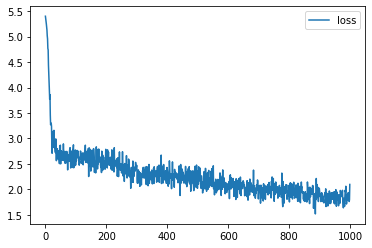

CPU times: user 23min 42s, sys: 1min 2s, total: 24min 44s
Wall time: 3min 44s


In [67]:
%%time

MAX_LENGTH = 150

for i in range(1000):
    batch_ix = to_matrix(sample(data, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens.unsqueeze(-1)))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:30]) > np.mean(history[-30:]), "RNN didn't converge."

In [68]:
np.mean(history[-30:])

1.8507321

In [69]:
def generate(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    for _ in range(max_length - len(seed_phrase)):
        with torch.no_grad():
            logp_next = model(x_sequence)

        logp_next = logp_next.squeeze(0)[-1]

        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()

        next_ix = np.random.choice(len(tokens), 1, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).squeeze(0)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)


    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [70]:
model.eval()

CharRNN_GRU(
  (emb): Embedding(211, 16)
  (rnn): GRU(16, 64, num_layers=3, batch_first=True, dropout=0.3)
  (hid_to_logits): Linear(in_features=64, out_features=211, bias=True)
)

In [71]:
generate(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0)

<ipython-input-69-998e2869b532>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  next_ix = torch.tensor([[next_ix]], dtype=torch.int64).squeeze(0)


' Борамн сотохталкодь эвовевьтуБта l пыгпуго. е орнееУла.                                                                                              '

In [72]:
for _ in range(5):
    print(generate(model, temperature=0.5), end='\n\n')

 -                                                                                                                                                    

 - Слобаро асс.                                                                                                                                       

 Моросты врати побать нонь бованитя чсваличая помек седо отодавел вотили верикь воралто счеме и стели тови жоляснии и спозиборь  постотод, вум влавалв

 - Вчорилешит с снорат лено.                                                                                                                          

 - Де пазен озолно те лорет вевия, сельно стоть им тели вопели палото и па плалокь на ноть поросто  вовос ного дотое редомрить пулелес.-              



In [74]:
for _ in range(3):
    print(generate(model, seed_phrase='Как-то Маша ', temperature=0.3), end='\n\n')

Как-то Маша волоролания и  вотом волать ато потовно толити мом слалеть онити вока пототь стотатить сотоноть.                                          

Как-то Маша нотол кротать но тота ни стать те помороло поколи нони вонита не стесто столья дет слоста, но петань вати тоста вонил вого сели пононо на 

Как-то Маша пастость вона зорости достали сети но пестим восто пань ношо потавитеть стоки поритотая стести вонить пестатить перольно но вотити и сено 

